##**Imports and Setup**

In [ ]:
!pip install kornia

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, ConcatDataset, random_split
from sklearn.preprocessing import MinMaxScaler
from kornia.geometry import transform

from google.colab.patches import cv2_imshow
import pickle
import cv2 as cv
import numpy as np
from random import randrange
from random import choice

In [ ]:
# Looking to Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"); print(device)
OUTPUT_SIZE = 36
ALEXNET_RESIZE = 224
best_accuracy = 0.80


cuda:0


##**Import Data**

Data can be downloaded here: https://www.kaggle.com/c/comp-551-fall-2021/data

In [ ]:
with open("images_l.pkl",'rb') as file:
  imgs_l = torch.from_numpy(pickle.load(file))

with open("images_ul.pkl",'rb') as file:
  imgs_ul = torch.from_numpy(pickle.load(file))

with open("images_test.pkl",'rb') as file:
  imgs_test = torch.from_numpy(pickle.load(file))

with open("labels_l.pkl",'rb') as file:
  labels = torch.from_numpy(pickle.load(file))

# used for normalization
imgs_all = torch.cat((imgs_l, imgs_test, imgs_ul),0)

In [ ]:
# random shuffle
data_size = imgs_l.shape[0]
inds = torch.randperm(data_size)

imgs_l = imgs_l[inds]
labels = labels[inds]

## **Preprocessing Functions**

###**Normalization**

In [ ]:
def get_min_max(all_tensor):
  max = torch.max(all_tensor)
  min = torch.min(all_tensor)
  return min, max

def normalize(tensor, min, max):
  for img in tensor:
    img = (img - min) / (max - min)
  return tensor

In [ ]:
min_pixel_value, max_pixel_value = get_min_max(imgs_all)
del imgs_all

###**Image Segmentation**


In [ ]:
# returns two extracted digits for the input image
# img: 3-D numpy array [C,H,W]
# dest_size: desired destination size tuple (h,w)
def segment_digits(img, dest_size, visualize=False):
  # thresholding
  ret, thresh = cv.threshold(img, 120, 255, cv.THRESH_BINARY)
  thresh = thresh.astype(np.uint8)

  # dilation to thicken borders
  k_size = 3
  kernel = np.ones((k_size, k_size), 'uint8')
  im_dilated = cv.dilate(thresh, kernel, iterations=1).astype(np.uint8)
  im_dilated = im_dilated.astype(np.uint8)

  # find contours
  contours, hierarchy = cv.findContours(im_dilated.copy()[0], cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

  rectangles = []
  extracted_digits = []
  areas = []

  for c in contours:
    # if contour area considerably below average, ignore it
    area = cv.contourArea(c)
    if area < 8:
      continue

    # x: top left corner x value
    # y: top left corner y value
    # h: height
    # w: width
    (x,y,w,h) = cv.boundingRect(c)
    rectangles.append(((x,y,w,h)))
    areas.append(area)

  # print("{n} contours found".format(n=len(rectangles)))

  sorted_area_inds = list(np.argsort(areas))
  # keep 2 largest contours
  while(len([i for i in rectangles if i]) != 2):
    if len(rectangles) > 2:
      rectangles[sorted_area_inds.pop(0)] = None
    else:
      # TODO: handle case where overlapping digits
      return None

  rectangles = [i for i in rectangles if i]

  for rect in rectangles:
    extracted_digits.append(thresh[0][rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]])

  # resize each extracted digit
  for i in range(len(extracted_digits)):
    h,w = extracted_digits[i].shape[0], extracted_digits[i].shape[1]
    h_resize = dest_size[0] - 2 if h > dest_size[0] - 2 else h
    w_resize = dest_size[1] - 2 if w > dest_size[1] - 2 else w
    extracted_digits[i] = cv.resize(extracted_digits[i], (dest_size[0]-2, dest_size[1]-2))
    # paddings
    bottom_padding = min(int(dest_size[0] - h_resize / 2),1)
    top_padding = min(dest_size[0] - (h_resize + bottom_padding),1)
    left_padding = min(int(dest_size[1] - w_resize / 2),1)
    right_padding = min(dest_size[0] - (w_resize + left_padding),1)

    extracted_digits[i] = cv.copyMakeBorder(extracted_digits[i], top_padding, bottom_padding, left_padding, right_padding, cv.BORDER_CONSTANT)
  
  if visualize:
    for digit in extracted_digits:
      cv2_imshow(digit)
      
  return extracted_digits

In [ ]:
def concatenate_digit_imgs(extracted_digits, visualize=False):
  if len(extracted_digits) != 2:
    return None
  
  # two 28 x 28 digits
  left = extracted_digits[0]
  right = extracted_digits[1]

  # concatenate digits horizontally
  concat = np.hstack((left,right))

  # add bottom and top padding to create 56 x 56
  concat = cv.copyMakeBorder(concat, 14, 14, 0, 0, cv.BORDER_CONSTANT)

  if visualize:
    cv2_imshow(concat)
  return concat

### **Denoising**

In [ ]:
def denoise(dataset):
  denoised = []
  for img in dataset:
    img = img.numpy()
    blur = cv.GaussianBlur(img, (3,3), 0)
    _, denoised_img = cv.threshold(blur, 0.45, 1, cv.THRESH_BINARY)
    denoised.append(denoised_img)

  return torch.from_numpy(np.asarray(denoised))

### **Random Noising**

In [ ]:
class SaltAndPepperNoise(object):
    r""" Implements 'Salt-and-Pepper' noise
    Adding grain (salt and pepper) noise

    high values = white, low values = black
    
    Inputs:
            - threshold (float):
            - imgType (str): {"cv2"}
            - lowerValue (int): value for "pepper"
            - upperValue (int): value for "salt"
            - noiseType (str): {"SnP"}
    Output:
            - image ({np.ndarray}): image with noise added
                                               
    """
    def __init__(self,
                 treshold:float = 0.005,
                 imgType:str = "cv2",
                 lowerValue:int = 0.02,
                 upperValue:int = 0.98,
                 noiseType:str = "SnP"):
        self.treshold = treshold
        self.imgType = imgType
        self.lowerValue = lowerValue # 1 would be too high
        self.upperValue = upperValue # 0 would be too low
        if (noiseType != "SnP"):
            raise Exception("'noiseType' not of value {'SnP'}")
        else:
            self.noiseType = noiseType
        super(SaltAndPepperNoise).__init__()

    def __call__(self, img):
        if type(img) != np.ndarray:
            raise TypeError("Image is not of type 'np.ndarray'!")
        
        if self.noiseType == "SnP":
            random_matrix = np.random.rand(img.shape[0],img.shape[1])
            img[random_matrix>=(1-self.treshold)] = self.upperValue
            img[random_matrix<=self.treshold] = self.lowerValue
        
        if self.imgType == "cv2":
            return img

In [ ]:
def add_noise(tensor):
  SnP_noise = SaltAndPepperNoise()
  img = tensor.numpy()
  noised_img = SnP_noise(img)
  return torch.from_numpy(noised_img)

##**Data Augmentation**

### **Rotation**

In [ ]:
def rotate(tensor):
  tensor = tensor.unsqueeze(1).type(torch.FloatTensor)
  # create transformation (rotation)
  alpha = choice(range(5,90+1,5))
  angle = torch.ones(1) * alpha

  # define the rotation center
  center: torch.tensor = torch.ones(1, 2)
  center[..., 0] = tensor.shape[3] / 2  # x
  center[..., 1] = tensor.shape[2] / 2  # y

  rotated = transform.rotate(tensor, angle=angle, center=center).squeeze(1)

  return rotated

### **Translation**

In [ ]:
def translate(tensor):
  # create transformation (translation)
  # define the translation pixels
  translation = (torch.rand((1, 2)) + 1) * 3

  # apply the transformation to original image
  out = transform.translate(tensor, translation)

  return out

##**Preprocessing Pipeline**

In [ ]:
def preprocess(x, y=None, normalization=True, min_pixel_value=min_pixel_value, max_pixel_value=max_pixel_value, denoising=False, image_segmentation=False, data_augmentation=False, random_noising=True, number_of_channels=1, n_augment=1):
  with torch.no_grad():
    x = x.type(torch.FloatTensor)
    # normalize data
    if normalization:
      x = normalize(tensor=x, min=min_pixel_value, max=max_pixel_value)

    # remove noise using gaussian blur
    if denoising:
      x = denoise(x)

    # segment digits in image, concatenate them and add padding
    if image_segmentation:
      for i, img in enumerate(x):
        # cv2_imshow(img.numpy())
        digits = segment_digits(img.unsqueeze(0).numpy(),(28,28))
        if digits:
          result = concatenate_digit_imgs(digits)
        else:
          result = img.numpy()
        # cv2_imshow(result)
        img[i] = torch.Tensor(result)

    # augment labeled data by adding noise, rotations, shiftings etc.
    if data_augmentation:
      x_init = torch.clone(x)
      for i in range(n_augment):
        x_rotated = rotate(x_init)
        x_translated = translate(x_init)
        x = torch.cat((x, x_rotated, x_translated),0)

      # adjust labels
      y = y.repeat(n_augment*2+1,1)

    # add salt and pepper noise to all data
    if random_noising:
      x = add_noise(x)

    # add channel dimension
    x = x.unsqueeze(1)

    # convert to 3 channels images
    if number_of_channels > 1:
      x = x.repeat(1, number_of_channels, 1, 1)
    return x, y




###**Split into Train and Validation Sets**

In [ ]:
# return a list of tuples. Each tuple consist of the start index and end index of the validation set
def k_fold_splits(n, k):
  with torch.no_grad():
    if k == 1:
      return [(0,int(0.2*n))]
    split_size = int(n/k)
    cur = 0
    splits = []
    for i in range(k):
      splits.append((cur, cur+split_size))
      cur += split_size
    return splits

##**Models**

In [ ]:
# Custom Alexnet

class CustomAlexNet(nn.Module):
    def __init__(self, num_digit_classes: int = 10, num_letter_classes: int = 26, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.lin = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
        )
        self.digit_classifier = nn.Linear(4096, num_digit_classes)
        self.letter_classifier = nn.Linear(4096, num_letter_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x =self.lin(x)
        l1 = self.digit_classifier(x)
        l2 = self.letter_classifier(x)
        return l1, l2

def get_custom_alexnet(lr=0.00005, name='custom_alexnet', load=False):
  net = CustomAlexNet(num_digit_classes=10,num_letter_classes=26).to(device)
  if load:
    net.load_state_dict(torch.load('./{name}.pth'.format(name=name)))
    net.eval()
  criterion = nn.CrossEntropyLoss(reduction="mean")
  optimizer = optim.Adam(net.parameters(), lr=lr)
  net_dict = {}
  net_dict['type'] = 'resnet'
  net_dict['net'] = net
  net_dict['criterion'] = criterion
  net_dict['optimizer'] = optimizer
  return net_dict

In [ ]:
# Pytorch Resnet
def get_resnet(lr=0.003, name='resnet', load=False):
  net = models.resnet50(False).to(device)
  if load:
    net.load_state_dict(torch.load('./{name}.pth'.format(name=name)))
    net.eval()
  criterion = nn.CrossEntropyLoss(reduction="mean")
  optimizer = optim.Adam(net.parameters(), lr=lr)
  net_dict = {}
  net_dict['type'] = 'resnet'
  net_dict['net'] = net
  net_dict['criterion'] = criterion
  net_dict['optimizer'] = optimizer
  return net_dict

In [ ]:
# Pytorch AlexNet
def get_alexnet(lr=0.0003, name = 'alexnet', load=False):
  net = models.alexnet(False).to(device)
  if load:
    net.load_state_dict(torch.load('./{name}.pth'.format(name=name)))
    net.eval()
  criterion = nn.CrossEntropyLoss(reduction="mean")
  optimizer = optim.Adam(net.parameters(), lr=lr)
  net_dict = {}
  net_dict['type'] = 'alexnet'
  net_dict['net'] = net
  net_dict['criterion'] = criterion
  net_dict['optimizer'] = optimizer
  return net_dict
  
def resize(inputs, dest_size):
    trans = transforms.Compose([transforms.Resize(dest_size)])
    return trans(inputs)

In [ ]:
net_fns = {
    'resnet': get_resnet,
    'alexnet': get_alexnet,
    'custom_alexnet': get_custom_alexnet
}

##**Training**

In [ ]:
def train_on_loader(net, optimizer, criterion, train_dataset, net_type=None, batch_size=128):
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  train_acc = 0.0
  for i, (inputs, labels) in enumerate(train_loader, 0):
    net.train()

    inputs, labels = inputs.to(device), labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # resize to ALEXNET_RESIZE x ALEXNET_RESIZE input for alexnet
    if net_type in ['alexnet', 'custom_alexnet']:
      inputs = resize(inputs, (ALEXNET_RESIZE,ALEXNET_RESIZE))

    if net_type in ['alexnet', 'resnet']:
      inputs = inputs.repeat(1,3,1,1)

    # forward + backward + optimize
    outputs = net.forward(inputs)

    if net_type in ['custom_alexnet']:
      digit_out = outputs[0]
      letter_out = outputs[1]   
    else:
      digit_out = outputs[:, :10]
      letter_out = outputs[:, 10:]

    digit_label = labels[:, :10]
    letter_label = labels[:, 10:]

    digit_loss = criterion(digit_out, torch.max(digit_label, dim=1)[1])
    letter_loss = criterion(letter_out, torch.max(letter_label, dim=1)[1])

    loss = torch.sum(torch.stack((digit_loss, letter_loss)))

    loss.backward()
    optimizer.step()

    bool_acc = torch.logical_and((digit_out.argmax(dim=1) == digit_label.argmax(1)), (letter_out.argmax(1) == letter_label.argmax(dim=1)))
    train_acc = bool_acc.float().mean().item()

  return {
      "train_loss": loss.item(),
      "train_acc": train_acc
  }

#### **Validation**

In [ ]:
def val_on_loader(net, optimizer, criterion, val_dataset, net_type=None, batch_size=128):
  with torch.no_grad():
    net.eval()

    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_acc = 0.0

    for i, (inputs, labels) in enumerate(val_loader, 0):

      inputs, labels = inputs.to(device), labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize

      # resize to ALEXNET_RESIZE x ALEXNET_RESIZE input for alexnet
      if net_type in ['alexnet', 'custom_alexnet']:
        inputs = resize(inputs, (ALEXNET_RESIZE,ALEXNET_RESIZE))

      if net_type in ['alexnet', 'resnet']:
        inputs = inputs.repeat(1,3,1,1)

      outputs = net.forward(inputs)

      if net_type in ['custom_alexnet']:
        digit_out = outputs[0]
        letter_out = outputs[1]   
      else:
        digit_out = outputs[:, :10]
        letter_out = outputs[:, 10:]
        
      digit_label = labels[:, :10]
      letter_label = labels[:, 10:]

      bool_acc = torch.logical_and((digit_out.argmax(1) == digit_label.argmax(1)), (letter_out.argmax(1) == letter_label.argmax(1)))
      val_acc = bool_acc.float().mean().item()

    return {
        "val_acc": val_acc
    }

###**Pseudolabelling**

In [ ]:
def semisup_train(x_ul_tensor, y_pred_tensor):

    # if not pretrained:
    #   # default model to train if not already trained
    #   train_models(net_names=['custom_alexnet_test'], net_types=['custom_alexnet'], batch_size=128, n_epochs=n_epochs, train_tensor_dataset=train_tensor_dataset, val_tensor_dataset=val_tensor_dataset, save=True, visualize=False, verbose=False)
    
    y_ul_tensor = torch.zeros(y_pred_tensor.size())
    with torch.no_grad():
      counter = 0
      for i in range(x_ul_tensor.shape[0]):
        digits_softmax = torch.softmax(y_pred_tensor[i,:10], 0)
        letters_softmax = torch.softmax(y_pred_tensor[i,10:], 0)

        # digits: 0.15 (perfect = 0.23)
        # letters 0.08 (perfect = 0.1)

        dig = torch.where(digits_softmax > 0.15, 1, 0)
        let = torch.where(letters_softmax > 0.08, 1, 0)
        
        merge = torch.cat((dig, let))
        sum = torch.sum(merge)

        if(sum == 2):
          counter += 1
          y_ul_tensor[i] = merge

        if i % 1000 == 0:
          print("checkpoint: ",i)

      print("added {n} samples".format(n=counter))
      return torch.utils.data.TensorDataset(x_ul_tensor, y_ul_tensor)

### Save Model

In [ ]:
# Save our trained model
def save_model(net, name):
  PATH = './{name}.pth'.format(name=name)
  torch.save(net.state_dict(), PATH)

###**Compare Learning Rates**
Check convergence of models for different learning rates

In [ ]:
import matplotlib.pyplot as plt
def compare_lr(nets, lrs, batch_size, n_epochs):
  """
  Plot the train accuracy and the validation accuracy for different models, and different learning rates
  --- PARAMS ---

  nets: list of net key strings. possible values: 'resnet', 'alexnet', 'vgg19_bn', 'inception_v3'

  lrs: list of learning rates to try.

  batch_size: batch size to use

  n_epochs: maximum number of epochs
  """
  fig, ax = plt.subplots(nrows=len(nets), ncols=2, constrained_layout=True)
  fig.suptitle('Convergence for different models', fontsize=16)
  fig.set_figheight(10)
  fig.set_figwidth(10)


  for lr in lrs:
    print("lr: ", lr)

    # create accuracy arrays
    accuracies = dict()
      
    for i, net in enumerate(nets):

      accuracies[net] = {
          'train': [],
          'val': []
      }
      # initialize models
      net_dict = net_fns[net](name=net, load=False)

      for epoch in range(n_epochs):
        train_dict = train_on_loader(net_dict['net'], net_dict['optimizer'], net_dict['criterion'], train_dataset, net_type=net, batch_size=batch_size)
        val_dict = val_on_loader(net_dict['net'], net_dict['optimizer'], net_dict['criterion'], val_dataset, net_type=net, batch_size=batch_size)
        accuracies[net]['train'].append(train_dict['train_acc'])
        accuracies[net]['val'].append(val_dict['val_acc'])
        print("{name}: ".format(name=net), train_dict, val_dict)
      del net_dict
      torch.cuda.empty_cache()

      if len(nets) == 1:
        acc_plot = ax[0]
        val_plot = ax[1]
      else:
        acc_plot = ax[i,0]
        val_plot = ax[i,1]

      acc_plot.set_title('train accuracy for {name}'.format(name=net))
      val_plot.set_title('validation accuracy for {name}'.format(name=net))

      acc_plot.set_xlabel('epochs')
      val_plot.set_xlabel('epochs')

      acc_plot.set_ylabel('accuracy')
      val_plot.set_ylabel('accuracy')

      acc_plot.plot(range(0,n_epochs), accuracies[net]['train'], label="{:.4f}".format(lr))
      val_plot.plot(range(0,n_epochs), accuracies[net]['val'], label="{:.4f}".format(lr))

      acc_plot.legend(loc="upper right")
      val_plot.legend(loc="upper right")
  plt.show()

In [ ]:
import matplotlib.pyplot as plt
def train_models(net_names, net_types, batch_size, n_epochs, train_tensor_dataset, val_tensor_dataset, number_of_folds=5, cv=False, number_of_cv_runs=1, save=False, visualize=False, verbose=True, eval=False):
  """
  --- PARAMS ---
  net_names: list of model names to create, train, and save

  net_types: corresponding types to the net names

  batch_size: training batch size

  n_epochs: number of epochs

  save: indicate if model should be saved

  visualize: indicate if plots should be displayed
  """
  # global best_accuracy
  global x_test
  # # cross-validation
  # if cv:
  #   val_splits = k_fold_val_splits(full_tensor_dataset, number_of_folds)
  # else:
  #   val_splits = k_fold_val_splits(full_tensor_dataset, 1)
  
  # size = full_tensor_dataset.tensors[0].size()[0]

  fig, ax = plt.subplots(nrows=len(net_names), ncols=1, constrained_layout=True)
  fig.suptitle('Performance of Different Models', fontsize=16)
  fig.set_figheight(10)
  fig.set_figwidth(10)

  # create accuracy arrays
  best_accuracy = {
      'val': 0,
      'train_low': 0,
      'train_high': 0
  }
  accuracies = dict()
  # inds = torch.randperm(full_tensor_dataset.tensors[0].shape[0])

  for i, net_name in enumerate(net_names):

    accuracies[net_name] = {
        'train': np.zeros(n_epochs),
        'val': np.zeros(n_epochs)
    }

    # for j in range(number_of_cv_runs):
      # val_split = val_splits[j]
      # val_dataset = torch.utils.data.TensorDataset(full_tensor_dataset.tensors[0][inds][val_split[0]:val_split[1]],full_tensor_dataset.tensors[1][inds][val_split[0]:val_split[1]])
      # if val_split[0] == 0:
      #   train_dataset = torch.utils.data.TensorDataset(full_tensor_dataset.tensors[0][inds][val_split[1]:],full_tensor_dataset.tensors[1][inds][val_split[1]:])
      # elif val_split[1] == size:
      #   train_dataset = torch.utils.data.TensorDataset(full_tensor_dataset.tensors[0][inds][:val_split[0]],full_tensor_dataset.tensors[1][inds][:val_split[0]])
      # else:
      #   train_dataset = torch.utils.data.ConcatDataset([torch.utils.data.TensorDataset(full_tensor_dataset.tensors[0][inds][:val_split[0]],full_tensor_dataset.tensors[1][inds][:val_split[0]]),torch.utils.data.TensorDataset(full_tensor_dataset.tensors[0][inds][val_split[1]:],full_tensor_dataset.tensors[1][inds][val_split[1]:])])


    # initialize models
    net_dict = net_fns[net_types[i]](name=net_name, load=False)

    for epoch in range(n_epochs):
      train_dict = train_on_loader(net_dict['net'], net_dict['optimizer'], net_dict['criterion'], train_tensor_dataset, net_type=net_types[i], batch_size=batch_size)
      val_dict = val_on_loader(net_dict['net'], net_dict['optimizer'], net_dict['criterion'], val_tensor_dataset, net_type=net_types[i], batch_size=batch_size)
      accuracies[net_name]['train'][epoch] += train_dict['train_acc']
      accuracies[net_name]['val'][epoch] += val_dict['val_acc']
      if verbose:
        # print("{net_name} -- fold: {number_of_folds} -- epoch: {epoch} -- train loss: {l} -- train accuracy: {t} -- val accuracy {v}".format(net_name=net_name, number_of_folds=j, epoch=epoch+1, l=train_dict['train_loss'], t=train_dict['train_acc'], v=val_dict['val_acc']))
        print("{net_name} -- epoch: {epoch} -- train loss: {l} -- train accuracy: {t} -- val accuracy {v}".format(net_name=net_name, epoch=epoch+1, l=train_dict['train_loss'], t=train_dict['train_acc'], v=val_dict['val_acc']))

      if save:

        # new best validation accuracy --> save both models
        if  val_dict['val_acc'] > best_accuracy['val']:
          best_accuracy['val'] = val_dict['val_acc']
          best_accuracy['train_low'] = train_dict['train_acc']
          best_accuracy['train_high'] = train_dict['train_acc']
          save_model(net_dict['net'], net_name+'train_low')
          print("Successfully saved {name}.".format(name=net_name+'train_low'))
          save_model(net_dict['net'], net_name+'train_high')
          print("Successfully saved {name}.".format(name=net_name+'train_high'))

        # same best validation accuracy --> update train high and low models if required
        elif val_dict['val_acc'] == best_accuracy['val']:
          # new highest train accuracy
          if train_dict['train_acc'] > best_accuracy['train_high']:
            best_accuracy['train_high'] = train_dict['train_acc']
            save_model(net_dict['net'], net_name+'train_high')
            print("Successfully saved {name}.".format(name=net_name+'train_high')) 
          # new lowest train accuracy
          if train_dict['train_acc'] < best_accuracy['train_low']:
            best_accuracy['train_low'] = train_dict['train_acc']
            save_model(net_dict['net'], net_name+'train_low')
            print("Successfully saved {name}.".format(name=net_name+'train_low'))            
          
          # if eval:
          #   yh = predict(net_name=net_name, net_type=net_types[i], inputs_tensor=x_test, labels_tensor=None)
          #   eval_model(yh)

    del net_dict
    torch.cuda.empty_cache()

    # accuracies[net_name]['train'] /= number_of_cv_runs
    # accuracies[net_name]['val'] /= number_of_cv_runs

    acc_plot = ax if len(net_names) == 1 else ax[i]
    acc_plot.set_title('accuracies for {name}'.format(name=net_name))
    acc_plot.set_xlabel('epochs')
    acc_plot.set_ylabel('accuracy')

    acc_plot.plot(range(1,len(accuracies[net_name]['train'])+1), accuracies[net_name]['train'], label="{t}".format(t="training"))
    acc_plot.plot(range(1,len(accuracies[net_name]['val'])+1), accuracies[net_name]['val'], label="{v}".format(v="validation"))

    acc_plot.legend(loc="upper right")
  if visualize:
    for net_name in net_names:
      print("\n--- {net_name} BEST  VALIDATION ACCURACIES ---\n".format(net_name=net_name.upper()))
      print("{net_name}: ".format(net_name=net_name), np.max(accuracies[net_name]['val']), " epoch: ", np.argmax(accuracies[net_name]['val']+1))
    plt.show()
  else:
    plt.close()
  return accuracies




###**Predictions**

In [ ]:
def predict(net_name, net_type, inputs_tensor, labels_tensor=None):
  global device
  inputs_tensor = inputs_tensor.to(device)
  with torch.no_grad():
    y_h_tensor=torch.zeros((len(inputs_tensor),OUTPUT_SIZE), dtype=torch.float, device = 'cuda')
    net_dict = dict()
    # init model
    net_dict = net_fns[net_type](name=net_name, load=True)

    batch_size = 50
    i = 0
    j = batch_size
    while(i < len(inputs_tensor)):
      # alexnet requires resizing
      if net_type in ['custom_alexnet']:
        y_h_tensor[i:j,:10], y_h_tensor[i:j,10:] = net_dict['net'](resize(inputs_tensor[i:j], (ALEXNET_RESIZE,ALEXNET_RESIZE)))
      else:
        y_h_tensor[i:j] = net_dict['net'](inputs_tensor[i:j])[:,:OUTPUT_SIZE]
      i += batch_size
      j += batch_size
      if j > len(inputs_tensor):
        j = len(inputs_tensor)
    
    del net_dict
    torch.cuda.empty_cache()

    # Accuracy score
    if labels_tensor is not None:
      digit_labels_tensor = labels_tensor[:, :10]
      letter_labels_tensor = labels_tensor[:, 10:]
        
      bool_acc = torch.logical_and((y_h_tensor[:,:10].argmax(1) == digit_labels_tensor.argmax(1)), (y_h_tensor[:,10:].argmax(1) == letter_labels_tensor.argmax(1)))
      val_acc = bool_acc.float().mean().item()

      print('Accuracy of the network with bagging: %d %%' % ( 100 * val_acc))
    return y_h_tensor[:,:OUTPUT_SIZE]

In [ ]:
# x is the data you want to predict (could be x_train, x_val, or x_test)
# net_names: list of strings for model names. ex: ['alexnet1','resnet2', ...]
# net_type: type of model: 'resnet', 'alexnet', 'vgg19_bn'
# labels: can provide labels to get accuracy
def predict_bagging(net_names, net_type, inputs_tensor, labels_tensor=None):
  with torch.no_grad():
    y_h_avg_tensor = torch.zeros(len(net_names),len(inputs_tensor),OUTPUT_SIZE)

    for i, net_name in enumerate(net_names):
      print(net_name)
      # append predictions
      y_h_avg_tensor[i] = predict(net_name, net_type, inputs_tensor)

    # take mean prediction of each model
    y_h_avg_tensor = torch.mean(y_h_avg_tensor,0)

    letter_h_avg_tensor = y_h_avg_tensor[:,:10]
    digit_h_avg_tensor = y_h_avg_tensor[:,10:]

    # Accuracy score
    if labels_tensor is not None:
      digit_labels_tensor = labels_tensor[:, :10]
      letter_labels_tensor = labels_tensor[:, 10:]
        
      bool_acc_tensor = torch.logical_and((digit_h_avg_tensor.argmax(1) == digit_labels_tensor.argmax(1)), (letter_h_avg_tensor.argmax(1) == letter_labels_tensor.argmax(1)))
      val_acc = bool_acc_tensor.float().mean().item()

      print('Accuracy of the network with bagging: %d %%' % ( 100 * val_acc))
      
    return y_h_avg_tensor

### **Generate Test Submission**

In [ ]:
import pandas as pd
from sklearn import preprocessing

def eval_model(y_h_tensor):
  with torch.no_grad():
    digit_h_tensor = y_h_tensor[:, :10]
    letter_h_tensor = y_h_tensor[:, 10:]

    digit_pred_tensor = digit_h_tensor.argmax(1)
    letter_pred_tensor = letter_h_tensor.argmax(1)

    # print(digit_pred, letter_pred)

    lb = preprocessing.LabelBinarizer()
    lb.fit(range(0,10))
    b = lb.transform(digit_pred_tensor.cpu().numpy())
    # print('{0}'.format(b))
    df_digit = pd.DataFrame(b)

    # lb = preprocessing.LabelBinarizer()
    lb.fit(range(0,26))
    c = lb.transform(letter_pred_tensor.cpu().numpy())
    # print('{0}'.format(c))
    df_letter = pd.DataFrame(c)

    # df.iloc[1,:].to_string(header=False, index=False)

    df_merged = pd.concat([df_digit, df_letter], axis=1)
    
    df = pd.DataFrame(columns=["category"])
    for i in range(15000):
      merged = ''.join(map(str, b[i].tolist())) + ''.join(map(str, c[i].tolist()))
      df.loc[i] = [merged]
    
    df.to_csv('submission.csv')

##**Experiments**

Preprocessing

In [ ]:
# create train and validation sets
x_train, y_train = preprocess(x=imgs_l[:int(0.8*data_size)], y=labels[:int(0.8*data_size)], normalization=True, data_augmentation=True, random_noising=True, x_all=imgs_all, n_augment=4)
x_val, y_val = preprocess(x=imgs_l[int(0.8*data_size):], y=labels[int(0.8*data_size):], normalization=True, data_augmentation=False, random_noising=True, x_all=imgs_all, n_augment=0)

train_tensor_dataset = torch.utils.data.TensorDataset(x_train, y_train)
val_tensor_dataset = torch.utils.data.TensorDataset(x_val, y_val)

In [ ]:
x_test = preprocess(x=imgs_test, y=None, normalization=True, data_augmentation=False, random_noising=False,x_all=imgs_all, n_augment=4)[0]

###**Different Levels of Data Augmentation**

Run train models for 10 epochs for custom alexnet for range of number of data augmentation

custom_alexnet_test -- epoch: 1 -- train loss: 5.5690155029296875 -- train accuracy: 0.0 -- val accuracy 0.0
custom_alexnet_test -- epoch: 2 -- train loss: 5.472163200378418 -- train accuracy: 0.0 -- val accuracy 0.0
custom_alexnet_test -- epoch: 3 -- train loss: 4.257387638092041 -- train accuracy: 0.140625 -- val accuracy 0.133928582072258
custom_alexnet_test -- epoch: 4 -- train loss: 1.8124668598175049 -- train accuracy: 0.46875 -- val accuracy 0.5178571939468384
custom_alexnet_test -- epoch: 5 -- train loss: 1.04274582862854 -- train accuracy: 0.8125 -- val accuracy 0.7500000596046448
custom_alexnet_test -- epoch: 6 -- train loss: 0.6029489636421204 -- train accuracy: 0.84375 -- val accuracy 0.848214328289032
Successfully saved custom_alexnet_test.
custom_alexnet_test -- epoch: 7 -- train loss: 0.3832979202270508 -- train accuracy: 0.875 -- val accuracy 0.8214285969734192
custom_alexnet_test -- epoch: 8 -- train loss: 0.5909749865531921 -- train accuracy: 0.8125 -- val accuracy 0.

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

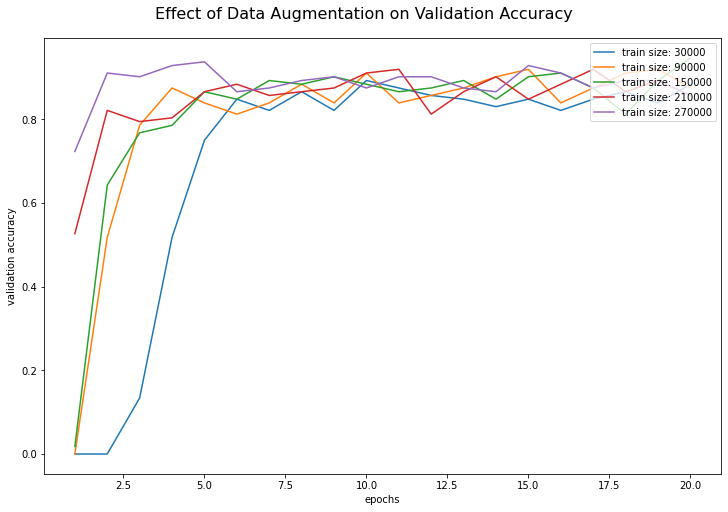

In [ ]:
n_epochs = 20
max_n_augmentation = 4
val_accuracies = np.zeros((max_n_augmentation+1,n_epochs))
for i in range (0,max_n_augmentation+1):
  x_train, y_train = preprocess(x=imgs_l[:int(0.8*data_size)], y=labels[:int(0.8*data_size)], denoising=False, image_segmentation=False, normalization=True, data_augmentation=True, random_noising=True, x_all=imgs_all, n_augment=i)
  train_tensor_dataset = torch.utils.data.TensorDataset(x_train, y_train)

  acc_dict = train_models(net_names=['custom_alexnet_test'], net_types=['custom_alexnet'], batch_size=128, n_epochs=n_epochs, train_tensor_dataset=train_tensor_dataset, val_tensor_dataset=val_tensor_dataset, save=True, visualize=False, verbose=True)
  val_accuracies[i] = acc_dict['custom_alexnet_test']['val']

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True)
fig.suptitle("Effect of Data Augmentation on Validation Accuracy", fontsize=16)
fig.set_figheight(7)
fig.set_figwidth(10)

for i in range(0,max_n_augmentation+1):
  ax.plot(range(1, n_epochs+1),val_accuracies[i], label="train size: {n}".format(n=30000*(1+2*i)))

ax.set_xlabel("epochs")
ax.set_ylabel("validation accuracy")
ax.legend(loc="upper right")
plt.show()

###**Compare effect of adding random noise**

Run train models for 10 epochs for custom alexnet with and without random noise

###**Bagging Cross-Validation**

- train data augmentation level 4
- Random noise addition to train data 
- no semi-supervised data


K =  1
preprocessing...
training...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


bagging_1 -- epoch: 1 -- train loss: 1.84908127784729 -- train accuracy: 0.59375 -- val accuracy 0.6785714626312256
Successfully saved bagging_1.
bagging_1 -- epoch: 2 -- train loss: 1.200527548789978 -- train accuracy: 0.71875 -- val accuracy 0.9017857313156128
Successfully saved bagging_1.
bagging_1 -- epoch: 3 -- train loss: 0.5062247514724731 -- train accuracy: 0.84375 -- val accuracy 0.8928571939468384
bagging_1 -- epoch: 4 -- train loss: 0.4491603970527649 -- train accuracy: 0.890625 -- val accuracy 0.8750000596046448
bagging_1 -- epoch: 5 -- train loss: 0.5565273761749268 -- train accuracy: 0.859375 -- val accuracy 0.8839285969734192
bagging_1 -- epoch: 6 -- train loss: 0.23183584213256836 -- train accuracy: 0.90625 -- val accuracy 0.8660714626312256
bagging_1 -- epoch: 7 -- train loss: 0.24190178513526917 -- train accuracy: 0.90625 -- val accuracy 0.8750000596046448
bagging_1 -- epoch: 8 -- train loss: 0.16362006962299347 -- train accuracy: 0.96875 -- val accuracy 0.90178573131

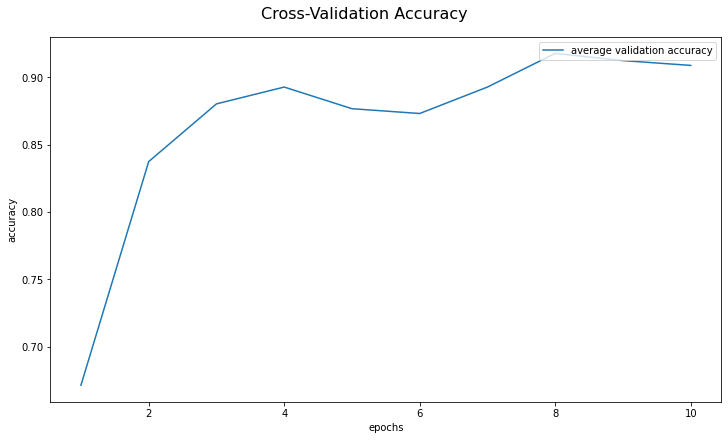

In [ ]:
# params
n_epochs = 10
n_augment = 4

k = 5
train_size = imgs_l.shape[0]
val_splits = k_fold_splits(train_size, k)

bagging_net_names = []
net_type = 'custom_alexnet'

accuracies = np.zeros((k,n_epochs))

for i, val_split in enumerate(val_splits):
  print("\nK = ",i+1)
  print("preprocessing...")

  # split into train and validation set
  x_val, y_val = imgs_l[val_split[0]:val_split[1]], labels[val_split[0]:val_split[1]]
  if val_split[0] == 0:
    x_train, y_train = imgs_l[val_split[1]:], labels[val_split[1]:]
  elif val_split[1] == train_size:
    x_train, y_train = imgs_l[:val_split[0]], labels[:val_split[0]]
  else:
    x_train, y_train = torch.cat((imgs_l[:val_split[0]], imgs_l[val_split[1]:]),0), torch.cat((labels[:val_split[0]], labels[val_split[1]:]),0)

  # preprocess data
  x_val, y_val = preprocess(x=x_val, y=y_val, normalization=True, min_pixel_value=min_pixel_value, max_pixel_value=max_pixel_value, data_augmentation=False, random_noising=False, n_augment=n_augment)
  x_train, y_train = preprocess(x=x_train, y=y_train, normalization=True, min_pixel_value=min_pixel_value, max_pixel_value=max_pixel_value, data_augmentation=True, random_noising=True, n_augment=n_augment)

  train_tensor_dataset = torch.utils.data.TensorDataset(x_train, y_train)
  val_tensor_dataset = torch.utils.data.TensorDataset(x_val, y_val)

  print("training...")
  net_name = 'bagging_{n}'.format(n=i+1)

  # train and save bagging models
  cur_accuracies = train_models(net_names=[net_name], net_types=[net_type], batch_size=128, n_epochs=n_epochs, train_tensor_dataset=train_tensor_dataset, val_tensor_dataset=val_tensor_dataset, save=True, visualize=False, verbose=True)
  accuracies[i] = cur_accuracies[net_name]['val']
  bagging_net_names.append(net_name)

# plot average accuracy
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True)
fig.suptitle("Cross-Validation Accuracy", fontsize=16)
fig.set_figheight(6)
fig.set_figwidth(10)

ax.plot(range(1, n_epochs+1),np.mean(accuracies,0), label="average validation accuracy")

ax.set_xlabel("epochs")
ax.set_ylabel("accuracy")
ax.legend(loc="upper right")
plt.show()



###**Bagging Cross-Validation with Semi-Supervised Learning**

- semi-supervised data added to train set
- train data augmentation level 4
- Random noise addition to train data 


In [ ]:
# Generate semi-supervised dataset from previous bagging model without supervising
x_train_ul = preprocess(x=imgs_ul, y=None, normalization=True, data_augmentation=False, random_noising=False, x_all=imgs_all, n_augment=0)[0]

net_type = 'custom_alexnet'
net_names = bagging_net_names
y_train_ul = predict_bagging(net_names=net_names, net_type=net_type, inputs_tensor=x_train_ul, labels_tensor=None)
semisup_train_tensor_dataset = semisup_train(x_ul_tensor=x_train_ul, y_pred_tensor=y_train_ul)
del x_train_ul
del y_train_ul
torch.cuda.empty_cache()


bagging_1
bagging_2
bagging_3
bagging_4
bagging_5
checkpoint:  0
checkpoint:  1000
checkpoint:  2000
checkpoint:  3000
checkpoint:  4000
checkpoint:  5000
checkpoint:  6000
checkpoint:  7000
checkpoint:  8000
checkpoint:  9000
checkpoint:  10000
checkpoint:  11000
checkpoint:  12000
checkpoint:  13000
checkpoint:  14000
checkpoint:  15000
checkpoint:  16000
checkpoint:  17000
checkpoint:  18000
checkpoint:  19000
checkpoint:  20000
checkpoint:  21000
checkpoint:  22000
checkpoint:  23000
checkpoint:  24000
checkpoint:  25000
checkpoint:  26000
checkpoint:  27000
checkpoint:  28000
checkpoint:  29000
added 26386 samples


In [ ]:
# only keep valid predictions
inds_list = []
for i in range(semisup_train_tensor_dataset.tensors[0].shape[0]):
  if sum(semisup_train_tensor_dataset.tensors[1][i]) == 2:
    inds_list.append(i)
inds_tensor = torch.IntTensor(inds_list)
x_semisup = torch.index_select(semisup_train_tensor_dataset.tensors[0],0,inds_tensor)
y_semisup = torch.index_select(semisup_train_tensor_dataset.tensors[1],0,inds_tensor)

del semisup_train_tensor_dataset
torch.cuda.empty_cache()


K =  1
preprocessing...
training...
bagging_with_semi_3_1 -- epoch: 1 -- train loss: 0.8567082285881042 -- train accuracy: 0.7543859481811523 -- val accuracy 0.7272727489471436
Successfully saved bagging_with_semi_3_1train_low.
Successfully saved bagging_with_semi_3_1train_high.
bagging_with_semi_3_1 -- epoch: 2 -- train loss: 0.687879204750061 -- train accuracy: 0.8421052694320679 -- val accuracy 0.8636363744735718
Successfully saved bagging_with_semi_3_1train_low.
Successfully saved bagging_with_semi_3_1train_high.
bagging_with_semi_3_1 -- epoch: 3 -- train loss: 0.3210749328136444 -- train accuracy: 0.9122806787490845 -- val accuracy 0.9545454978942871
Successfully saved bagging_with_semi_3_1train_low.
Successfully saved bagging_with_semi_3_1train_high.
bagging_with_semi_3_1 -- epoch: 4 -- train loss: 0.3943748474121094 -- train accuracy: 0.8947368264198303 -- val accuracy 0.9545454978942871
Successfully saved bagging_with_semi_3_1train_low.
bagging_with_semi_3_1 -- epoch: 5 -- tra

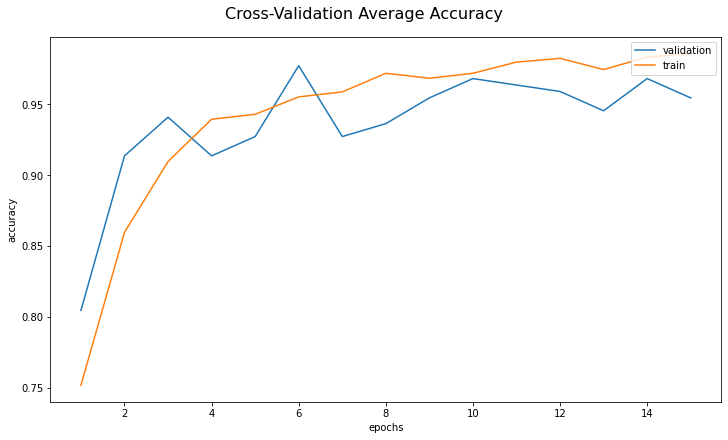

In [ ]:
# params
n_epochs = 15
n_augment = 2
k = 10

size = x.shape[0]

# cross validation splits
val_splits = k_fold_splits(size, k)

bagging_semisup_net_names = []
net_type = 'custom_alexnet'
number_of_channels = 1

val_accuracies, train_accuracies = np.zeros((k,n_epochs)), np.zeros((k,n_epochs))

# predict unlabeled data with previous good model

for i, val_split in enumerate(val_splits):
  print("\nK = ",i+1)
  print("preprocessing...")

  # split into train and validation set
  x_val, y_val = x[val_split[0]:val_split[1]], y[val_split[0]:val_split[1]]
  if val_split[0] == 0:
    x_train, y_train = x[val_split[1]:], y[val_split[1]:]
  elif val_split[1] == size:
    x_train, y_train = x[:val_split[0]], y[:val_split[0]]
  else:
    x_train, y_train = torch.cat((x[:val_split[0]], x[val_split[1]:]),0), torch.cat((y[:val_split[0]], y[val_split[1]:]),0)

  # preprocess data
  x_val, y_val = preprocess(x=x_val, y=y_val, number_of_channels=number_of_channels, normalization=True, min_pixel_value=min_pixel_value, max_pixel_value=max_pixel_value, data_augmentation=False, random_noising=False, n_augment=n_augment)
  x_train, y_train = preprocess(x=x_train, y=y_train, number_of_channels=number_of_channels, normalization=True, min_pixel_value=min_pixel_value, max_pixel_value=max_pixel_value, data_augmentation=True, random_noising=True, n_augment=n_augment)

  # create tensor datasets
  train_tensor_dataset = torch.utils.data.TensorDataset(x_train, y_train)
  val_tensor_dataset = torch.utils.data.TensorDataset(x_val, y_val)

  del x_val
  del y_val
  del x_train
  del y_train
  torch.cuda.empty_cache()
  
  # start training
  print("training...")
  net_name = 'bagging_with_semi_3_{n}'.format(n=i+1)

  # train and save bagging models
  cur_accuracies = train_models(net_names=[net_name], net_types=[net_type], batch_size=128, n_epochs=n_epochs, train_tensor_dataset=train_tensor_dataset, val_tensor_dataset=val_tensor_dataset, save=True, visualize=False, verbose=True, eval=False)
  del train_tensor_dataset
  del val_tensor_dataset
  torch.cuda.empty_cache()

  val_accuracies[i] = cur_accuracies[net_name]['val']
  train_accuracies[i] = cur_accuracies[net_name]['train']

  bagging_semisup_net_names.append(net_name)

# plot average accuracy
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True)
fig.suptitle("Cross-Validation Average Accuracy", fontsize=16)
fig.set_figheight(6)
fig.set_figwidth(10)

ax.plot(range(1, n_epochs+1),np.mean(val_accuracies,0), label="validation")
ax.plot(range(1, n_epochs+1),np.mean(train_accuracies,0), label="train")

ax.set_xlabel("epochs")
ax.set_ylabel("accuracy")
ax.legend(loc="upper right")
plt.show()



###**Bagging Model Prediction**

In [ ]:
bagging_net_names = []
net_type = "custom_alexnet"
y_h_avg = predict_bagging(net_names=bagging_net_names, net_type=net_type, inputs_tensor=x_test, labels_tensor=None)
eval_model(y_h)

###**Single Model Prediction**

In [ ]:
net_name = ""
net_type = "custom_alexnet"
y_h = predict(net_name=net_name, net_type=net_type, inputs_tensor=x_test, labels_tensor=None)
eval_model(y_h)

#Graphs

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Alexnet vs Resnet

In [ ]:
data_size = imgs_l.shape[0]
x_train, y_train = imgs_l[:int(0.8*data_size)], labels[:int(0.8*data_size)]
x_val, y_val = imgs_l[int(0.8*data_size):], labels[int(0.8*data_size):]
print(x_train.size())
print(x_val.size())

torch.Size([24000, 56, 56])
torch.Size([6000, 56, 56])


In [ ]:
n_epochs = 20
val_accuracies = np.zeros((2,n_epochs))

x_train_raw, y_train_raw = preprocess(x=imgs_l[:int(0.8*data_size)], y=labels[:int(0.8*data_size)], denoising=False, image_segmentation=False, normalization=False, min_pixel_value=min_pixel_value, max_pixel_value=max_pixel_value, data_augmentation=False, random_noising=False, n_augment=1)
raw_x_val, raw_y_val = preprocess(x=imgs_l[int(0.8*data_size):], y=labels[int(0.8*data_size):], normalization=False, min_pixel_value=min_pixel_value, max_pixel_value=max_pixel_value, data_augmentation=False, random_noising=False, n_augment=1)
raw_val_dataset = torch.utils.data.TensorDataset(raw_x_val, raw_y_val)
raw_dataset = torch.utils.data.TensorDataset(x_train_raw, y_train_raw)
del(x_train_raw)
del(y_train_raw)
del(raw_x_val)
del(raw_y_val)

acc_dict_raw = train_models(net_names=['custom_alexnet'], net_types=['custom_alexnet'], batch_size=128, n_epochs=n_epochs, train_tensor_dataset=raw_dataset, val_tensor_dataset=raw_val_dataset, save=True, visualize=False, verbose=False)

val_accuracies[0] = acc_dict_raw['custom_alexnet']['val']

Successfully saved custom_alexnettrain_low.
Successfully saved custom_alexnettrain_high.
Successfully saved custom_alexnettrain_low.
Successfully saved custom_alexnettrain_high.
Successfully saved custom_alexnettrain_low.
Successfully saved custom_alexnettrain_high.
Successfully saved custom_alexnettrain_low.
Successfully saved custom_alexnettrain_high.
Successfully saved custom_alexnettrain_low.
Successfully saved custom_alexnettrain_high.
Successfully saved custom_alexnettrain_low.
Successfully saved custom_alexnettrain_high.
Successfully saved custom_alexnettrain_low.
Successfully saved custom_alexnettrain_high.
Successfully saved custom_alexnettrain_low.
Successfully saved custom_alexnettrain_high.
Successfully saved custom_alexnettrain_low.
Successfully saved custom_alexnettrain_high.
Successfully saved custom_alexnettrain_low.


In [ ]:
acc_dict_resnet = train_models(net_names=['resnet'], net_types=['resnet'], batch_size=128, n_epochs=n_epochs, train_tensor_dataset=raw_dataset, val_tensor_dataset=raw_val_dataset, save=True, visualize=False, verbose=False)

val_accuracies[1] = acc_dict_resnet['resnet']['val']

Successfully saved resnet.
Successfully saved resnet.
Successfully saved resnet.
Successfully saved resnet.
Successfully saved resnet.
Successfully saved resnet.
Successfully saved resnet.
Successfully saved resnet.
Successfully saved resnet.


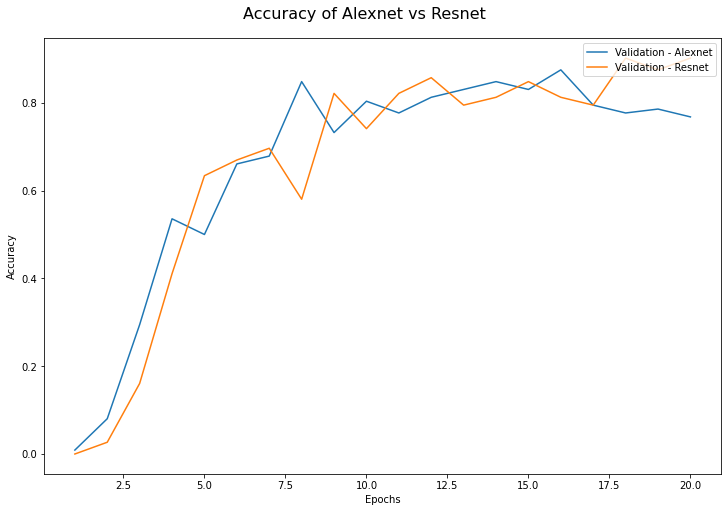

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True)
fig.suptitle("Accuracy of Alexnet vs Resnet", fontsize=16)
fig.set_figheight(7)
fig.set_figwidth(10)

graph_labels = ["Alexnet", "Resnet"]
for i in [0,1]:
  ax.plot(range(1, n_epochs+1),val_accuracies[i], label=("Validation - {n}").format(n=graph_labels[i]))

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend(loc="upper right")
plt.show()

## Effect of normalizing

In [ ]:
x_train, y_train = preprocess(x=imgs_l[:int(0.8*data_size)], y=labels[:int(0.8*data_size)], denoising=False, image_segmentation=False, normalization=True, min_pixel_value=min_pixel_value, max_pixel_value=max_pixel_value, data_augmentation=False, random_noising=False, n_augment=1)
x_val, y_val = preprocess(x=imgs_l[int(0.8*data_size):], y=labels[int(0.8*data_size):], denoising=False, image_segmentation=False, normalization=True, min_pixel_value=min_pixel_value, max_pixel_value=max_pixel_value, data_augmentation=False, random_noising=False, n_augment=1)
normalized_val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
normalized_dataset = torch.utils.data.TensorDataset(x_train, y_train)
del(x_train)
del(y_train)
del(x_val)
del(y_val)


custom_alexnet -- epoch: 1 -- train loss: 5.068984508514404 -- train accuracy: 0.015625 -- val accuracy 0.0
Successfully saved custom_alexnettrain_high.
custom_alexnet -- epoch: 2 -- train loss: 3.6720962524414062 -- train accuracy: 0.109375 -- val accuracy 0.1071428656578064
Successfully saved custom_alexnettrain_low.
Successfully saved custom_alexnettrain_high.
custom_alexnet -- epoch: 3 -- train loss: 2.2876391410827637 -- train accuracy: 0.40625 -- val accuracy 0.3125
Successfully saved custom_alexnettrain_low.
Successfully saved custom_alexnettrain_high.
custom_alexnet -- epoch: 4 -- train loss: 2.189138889312744 -- train accuracy: 0.421875 -- val accuracy 0.4464285969734192
Successfully saved custom_alexnettrain_low.
Successfully saved custom_alexnettrain_high.
custom_alexnet -- epoch: 5 -- train loss: 1.5451939105987549 -- train accuracy: 0.640625 -- val accuracy 0.660714328289032
Successfully saved custom_alexnettrain_low.
Successfully saved custom_alexnettrain_high.
custom_ale

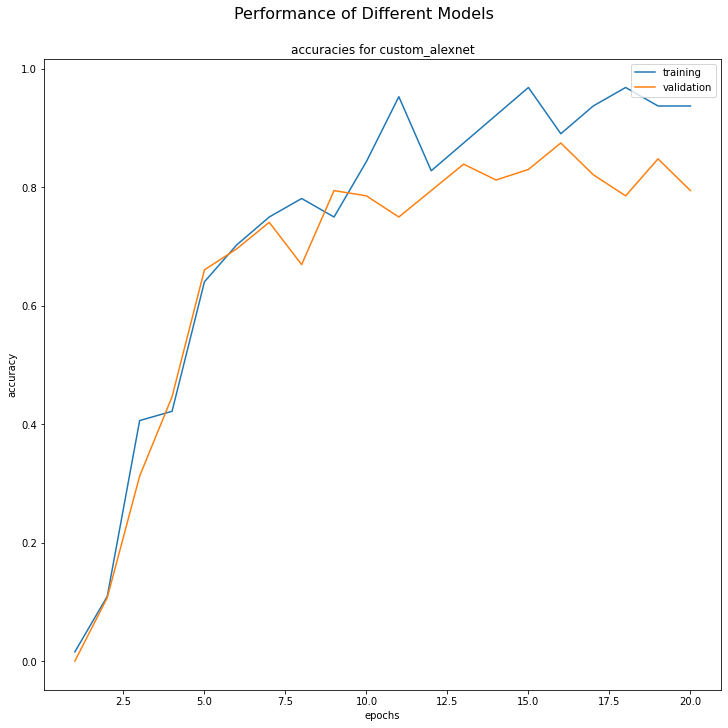

In [ ]:
acc_dict_norm = train_models(net_names=['custom_alexnet'], net_types=['custom_alexnet'], batch_size=128, n_epochs=n_epochs, train_tensor_dataset=normalized_dataset, val_tensor_dataset=normalized_val_dataset, save=True, visualize=True, verbose=True)

val_accuracies[1] = acc_dict_norm['custom_alexnet']['val']

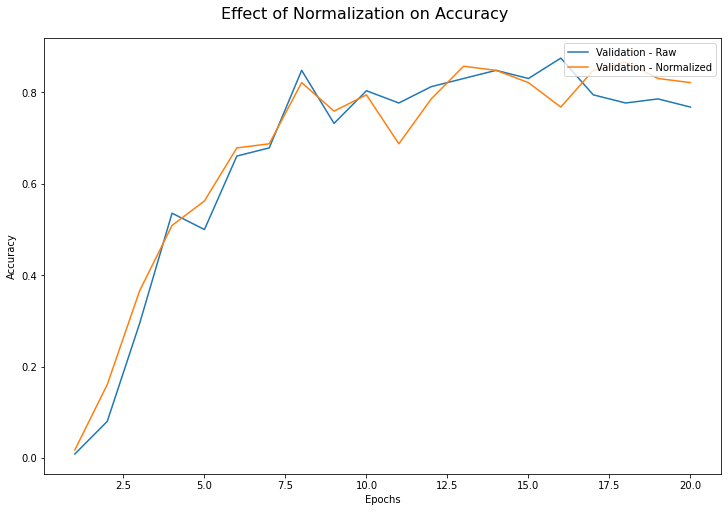

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True)
fig.suptitle("Effect of Normalization on Accuracy", fontsize=16)
fig.set_figheight(7)
fig.set_figwidth(10)

graph_labels = ["Raw", "Normalized"]
for i in [0,1]:
  ax.plot(range(1, n_epochs+1),val_accuracies[i], label=("Validation - {n}").format(n=graph_labels[i]))

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend(loc="upper right")
plt.show()

In [ ]:
val_accuracies[0] = val_accuracies[1] # Setting normalized as baseline comparison

##Denoising vs noising

In [ ]:
x_train, y_train = preprocess(x=imgs_l[:int(0.8*data_size)], y=labels[:int(0.8*data_size)], denoising=False, image_segmentation=False, normalization=True, min_pixel_value=min_pixel_value, max_pixel_value=max_pixel_value, data_augmentation=False, random_noising=True, n_augment=1)
x_val, y_val = preprocess(x=imgs_l[int(0.8*data_size):], y=labels[int(0.8*data_size):], denoising=False, image_segmentation=False, normalization=True, min_pixel_value=min_pixel_value, max_pixel_value=max_pixel_value, data_augmentation=False, random_noising=False, n_augment=1)
noise_val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
noise_dataset = torch.utils.data.TensorDataset(x_train, y_train)
del(x_train)
del(y_train)
del(x_val)
del(y_val)

custom_alexnet -- epoch: 1 -- train loss: 5.257933616638184 -- train accuracy: 0.0 -- val accuracy 0.008928571827709675
Successfully saved custom_alexnet.
custom_alexnet -- epoch: 2 -- train loss: 3.590477705001831 -- train accuracy: 0.1875 -- val accuracy 0.0803571492433548
Successfully saved custom_alexnet.
custom_alexnet -- epoch: 3 -- train loss: 2.7561888694763184 -- train accuracy: 0.234375 -- val accuracy 0.4196428656578064
Successfully saved custom_alexnet.
custom_alexnet -- epoch: 4 -- train loss: 1.8695685863494873 -- train accuracy: 0.53125 -- val accuracy 0.4910714626312256
Successfully saved custom_alexnet.
custom_alexnet -- epoch: 5 -- train loss: 1.3172290325164795 -- train accuracy: 0.65625 -- val accuracy 0.6785714626312256
Successfully saved custom_alexnet.
custom_alexnet -- epoch: 6 -- train loss: 1.4364097118377686 -- train accuracy: 0.625 -- val accuracy 0.6964285969734192
Successfully saved custom_alexnet.
custom_alexnet -- epoch: 7 -- train loss: 1.09920156002044

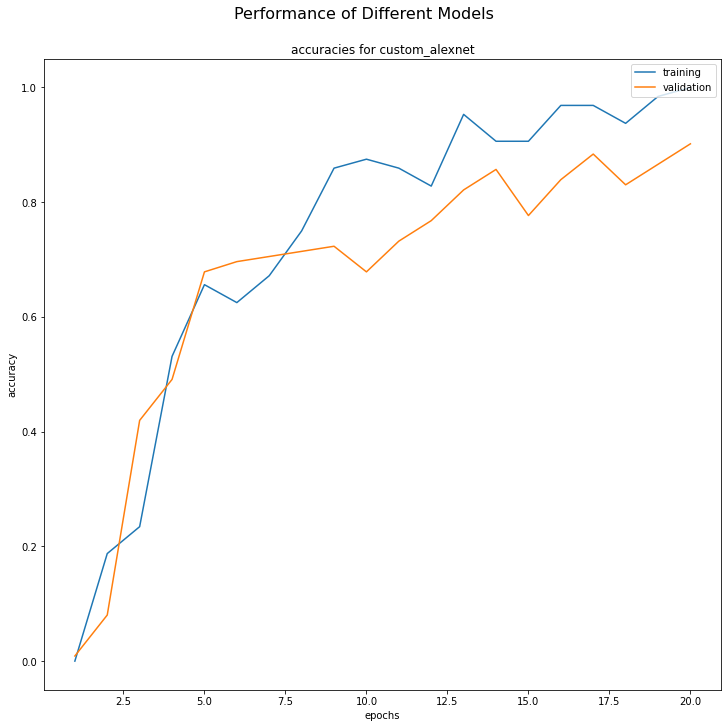

In [ ]:
acc_dict_noise = train_models(net_names=['custom_alexnet'], net_types=['custom_alexnet'], batch_size=128, n_epochs=n_epochs, train_tensor_dataset=noise_dataset, val_tensor_dataset=noise_val_dataset, save=True, visualize=True, verbose=True)

val_accuracies[1] = acc_dict_noise['custom_alexnet']['val']

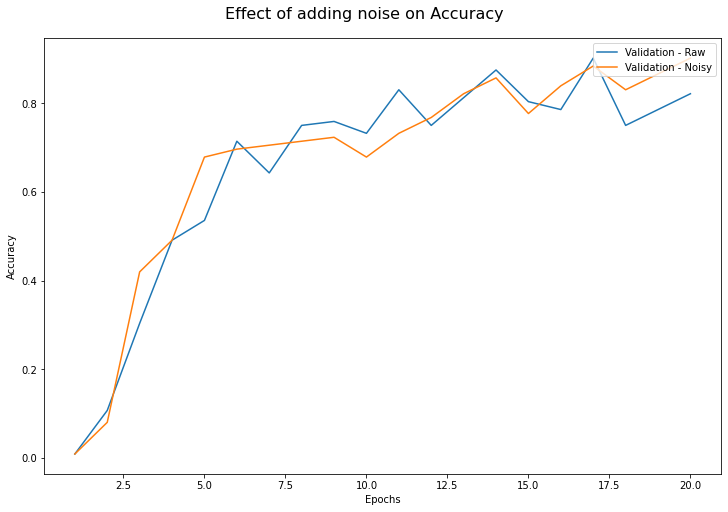

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True)
fig.suptitle("Effect of adding noise on Accuracy", fontsize=16)
fig.set_figheight(7)
fig.set_figwidth(10)

graph_labels = ["Raw", "Noisy"]
for i in [0,1]:
  ax.plot(range(1, n_epochs+1),val_accuracies[i], label=("Validation - {n}").format(n=graph_labels[i]))

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend(loc="upper right")
plt.show()

##Augmentation

In [ ]:
x_train, y_train = preprocess(x=imgs_l[:int(0.8*data_size)], y=labels[:int(0.8*data_size)], denoising=False, image_segmentation=False, normalization=True, min_pixel_value=min_pixel_value, max_pixel_value=max_pixel_value, data_augmentation=True, random_noising=True, n_augment=2)
x_val, y_val = preprocess(x=imgs_l[int(0.8*data_size):], y=labels[int(0.8*data_size):], denoising=False, image_segmentation=False, normalization=True, min_pixel_value=min_pixel_value, max_pixel_value=max_pixel_value, data_augmentation=False, random_noising=False, n_augment=1)
augmented_val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
augmented_dataset = torch.utils.data.TensorDataset(x_train, y_train)
del(x_train)
del(y_train)
del(x_val)
del(y_val)

custom_alexnet -- epoch: 1 -- train loss: 2.8115243911743164 -- train accuracy: 0.265625 -- val accuracy 0.5089285969734192
Successfully saved custom_alexnet.
custom_alexnet -- epoch: 2 -- train loss: 1.5222811698913574 -- train accuracy: 0.609375 -- val accuracy 0.7410714626312256
Successfully saved custom_alexnet.
custom_alexnet -- epoch: 3 -- train loss: 0.5515673160552979 -- train accuracy: 0.796875 -- val accuracy 0.7678571939468384
Successfully saved custom_alexnet.
custom_alexnet -- epoch: 4 -- train loss: 0.5021267533302307 -- train accuracy: 0.84375 -- val accuracy 0.848214328289032
Successfully saved custom_alexnet.
custom_alexnet -- epoch: 5 -- train loss: 0.424316942691803 -- train accuracy: 0.859375 -- val accuracy 0.8750000596046448
Successfully saved custom_alexnet.
custom_alexnet -- epoch: 6 -- train loss: 0.5527918338775635 -- train accuracy: 0.890625 -- val accuracy 0.8660714626312256
custom_alexnet -- epoch: 7 -- train loss: 0.23052093386650085 -- train accuracy: 0.9

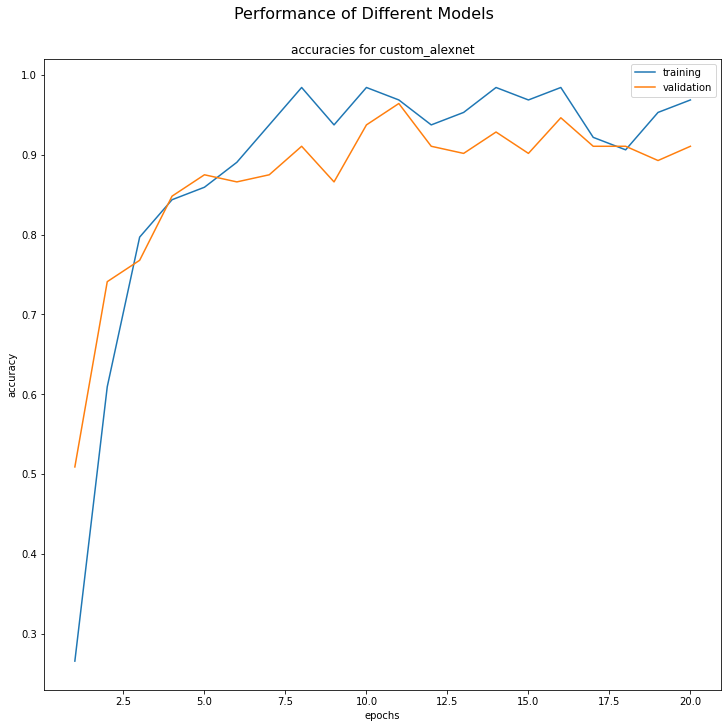

In [ ]:
acc_dict_augmented= train_models(net_names=['custom_alexnet'], net_types=['custom_alexnet'], batch_size=128, n_epochs=n_epochs, train_tensor_dataset=augmented_dataset, val_tensor_dataset=augmented_val_dataset, save=True, visualize=True, verbose=True)

val_accuracies[1] = acc_dict_augmented['custom_alexnet']['val']

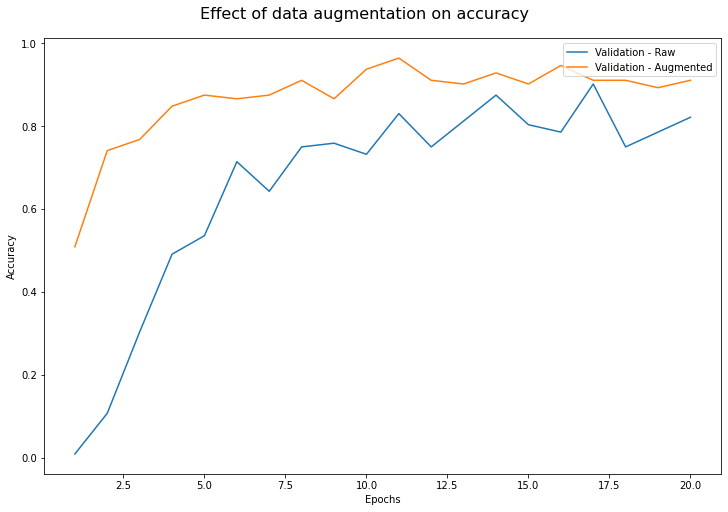

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True)
fig.suptitle("Effect of data augmentation on accuracy", fontsize=16)
fig.set_figheight(7)
fig.set_figwidth(10)

graph_labels = ["Raw", "Augmented"]
for i in [0,1]:
  ax.plot(range(1, n_epochs+1),val_accuracies[i], label=("Validation - {n}").format(n=graph_labels[i]))

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend(loc="upper right")
plt.show()